In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PriorVAE reimplementation

For a 1D GP

In [7]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro

from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive


In [8]:
from reusable.kernels import esq_kernel
from reusable.util import load_args

args = load_args("01", "args")


### Examples of priors to encode

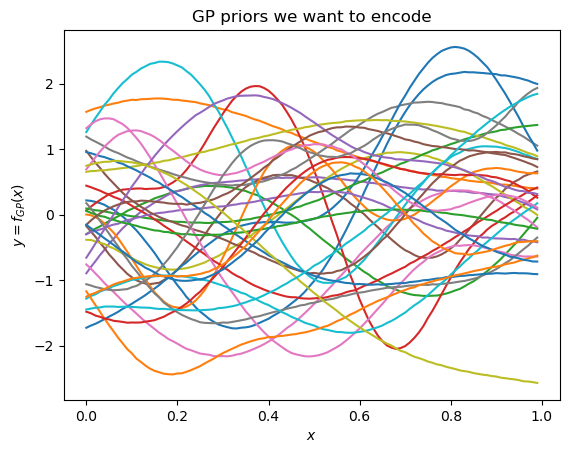

In [9]:
from reusable.gp import OneDGP
from plotting.plots import plot_draws

# create grid and draw priors
x_locs = args["x"]
rng_key, rng_key_example_priors = random.split(random.PRNGKey(4))
gp_predictive = Predictive(OneDGP, num_samples=args["batch_size"])
gp_draws = gp_predictive(rng_key_example_priors, x=x_locs, gp_kernel = args["gp_kernel"], jitter=1e-5)['y']
plot_draws(gp_draws, x_locs, title='GP priors we want to encode', ylabel="$y=f_{GP}(x)$")


## SVI to learn VAE parameters

### First check model structure
Which seems to be correct - take in a vector length n, output 2 vectors of size "latent_dim", one mean, one covariance

and the decoder takes a point sampled from that dist, to generate an approximation to the original 



In [10]:
from reusable.vae import VAE_Encoder, VAE_Decoder

print(VAE_Encoder(hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"]).tabulate(random.PRNGKey(0), gp_draws[1],  console_kwargs={'width': 140}))

print(VAE_Decoder(hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    out_dim=args["n"]).tabulate(random.PRNGKey(0), jnp.ones((args["latent_dim"],)), console_kwargs={'width': 140}))

print(VAE_Decoder(hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    out_dim=args["n"]).init(random.PRNGKey(0), jnp.ones((args["latent_dim"],))))


                                 VAE_Encoder Summary                                  
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module      ┃ inputs       ┃ outputs       ┃ params                  ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│             │ VAE_Encoder │ float32[100] │ - float32[30] │                         │
│             │             │              │ - float32[30] │                         │
├─────────────┼─────────────┼──────────────┼───────────────┼─────────────────────────┤
│ ENC Hidden1 │ Dense       │ float32[100] │ float32[35]   │ bias: float32[35]       │
│             │             │              │               │ kernel: float32[100,35] │
│             │             │              │               │                         │
│             │             │              │               │ 3,535 (14.1 KB)         │
├─────────────┼─────────────┼─────────────

### Training progress

In [12]:
from reusable.util import gen_file_name, load_training_state, load_training_history


dummy_decoder = VAE_Decoder(args["hidden_dim1"], args["hidden_dim2"], args["n"])
dummy_params = dummy_decoder.init(
    random.PRNGKey(0), jnp.ones((args["latent_dim"],))
)

decoder_params = load_training_state("01", gen_file_name("01", args), dummy_params)
args["decoder_params"] = decoder_params 

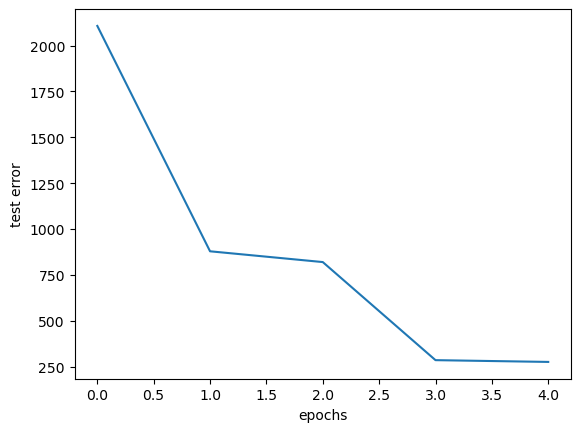

In [13]:

test_losses = load_training_history("01", gen_file_name("01", args))

import matplotlib.pyplot as plt

plt.figure()
plt.plot(jnp.arange(len(test_losses)), test_losses, label="test loss")
plt.xlabel("epochs")
plt.ylabel("test error")
plt.show()

## Demonstrations

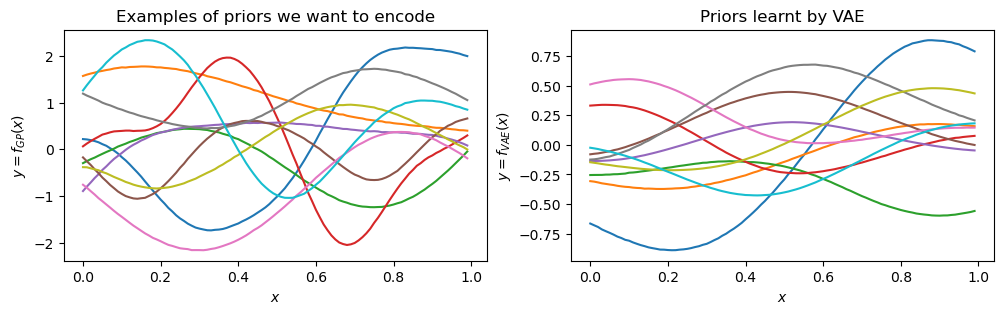

In [14]:
from reusable.vae import vae_sample
from plotting.plots import quick_compare_draws
rng_key, rng_key_predict = random.split(random.PRNGKey(2))
vae_predictive = Predictive(vae_sample, num_samples=10)
vae_draws = vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]

quick_compare_draws(args["x"], gp_draws, vae_draws)

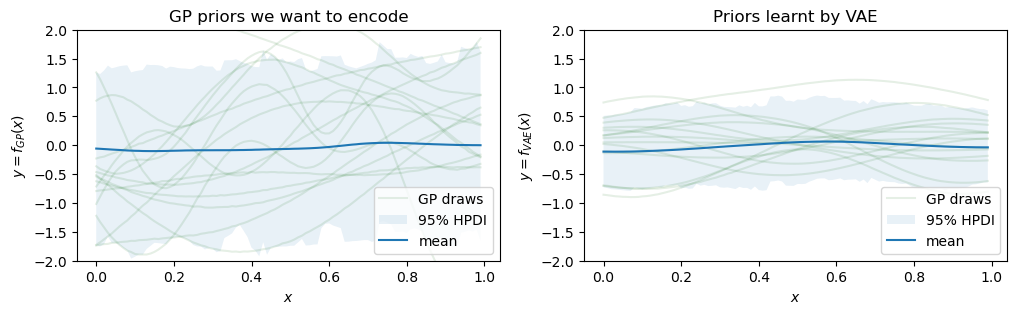

In [15]:
from reusable.vae import vae_sample
from plotting.plots import compare_draws
rng_key, rng_key_predict = random.split(random.PRNGKey(2))

plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
vae_draws = plot_vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]

compare_draws(args["x"], gp_draws, vae_draws, "GP priors we want to encode", "Priors learnt by VAE", '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$', save_path="gen_plots/01_prior_comp.png")


# Inference

In [18]:
args.update({
    
    # MCMC parameters
    "num_warmup": 1000,
    "num_samples": 1000,
    "thinning": 1,
    "num_chains": 3,



})

In [19]:
import os


def run_mcmc(rng_key, model_mcmc, y_obs, obs_idx, verbose=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(
        rng_key,
        args["hidden_dim1"],
        args["hidden_dim2"],
        args["latent_dim"],
        args["n"],
        args["decoder_params"],
        y=y_obs,
        obs_idx=obs_idx,
    )
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc.get_samples()


In [20]:
from reusable.mcmc import vae_mcmc

rng_key_ground_truth = random.PRNGKey(
    1
)  # fixed to generate a "ground truth" GP we will try and infer

ground_truth_predictive = Predictive(OneDGP, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"], noise=True
)
ground_truth = gt_draws["f"].T
ground_truth_y_draw = gt_draws["y"].T


x_obs_lst = []
y_obs_lst = []
predictions_lst = []

obs_idx_lst = [[22, 50], [16, 33, 57, 96], [8, 24, 45, 61, 77, 84]]


for i in range(len(obs_idx_lst)):
    obs_idx = jnp.array(obs_idx_lst[i])

    y_obs = ground_truth_y_draw[obs_idx, 0]
    x_obs = args["x"][obs_idx]

    rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

    # inference
    mcmc_samples = run_mcmc(rng_key_post, vae_mcmc, y_obs, obs_idx)
    # hidden_dim1, hidden_dim2, latent_dim, out_dim, decoder_params
    predictive = Predictive(vae_mcmc, mcmc_samples)
    predictions = predictive(
        rng_key_pred,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"],
    )["f"]

    x_obs_lst.append(x_obs)
    y_obs_lst.append(y_obs)
    obs_idx_lst.append(obs_idx)
    predictions_lst.append(predictions)


prior_predictive = Predictive(vae_mcmc, num_samples=10000)
prior_predictions = prior_predictive(rng_key_prior,  hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"])["y_pred"]

/tmp/ipykernel_37551/3108940662.py:9: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:02<00:00, 767.05it/s, 13 steps of size 4.94e-02. acc. prob=0.91] 



MCMC elapsed time: 16.487231492996216


/tmp/ipykernel_37551/3108940662.py:9: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:02<00:00, 707.81it/s, 31 steps of size 1.90e-01. acc. prob=0.89]



MCMC elapsed time: 14.844836235046387


/tmp/ipykernel_37551/3108940662.py:9: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:02<00:00, 675.24it/s, 31 steps of size 1.54e-01. acc. prob=0.88]



MCMC elapsed time: 13.441035270690918


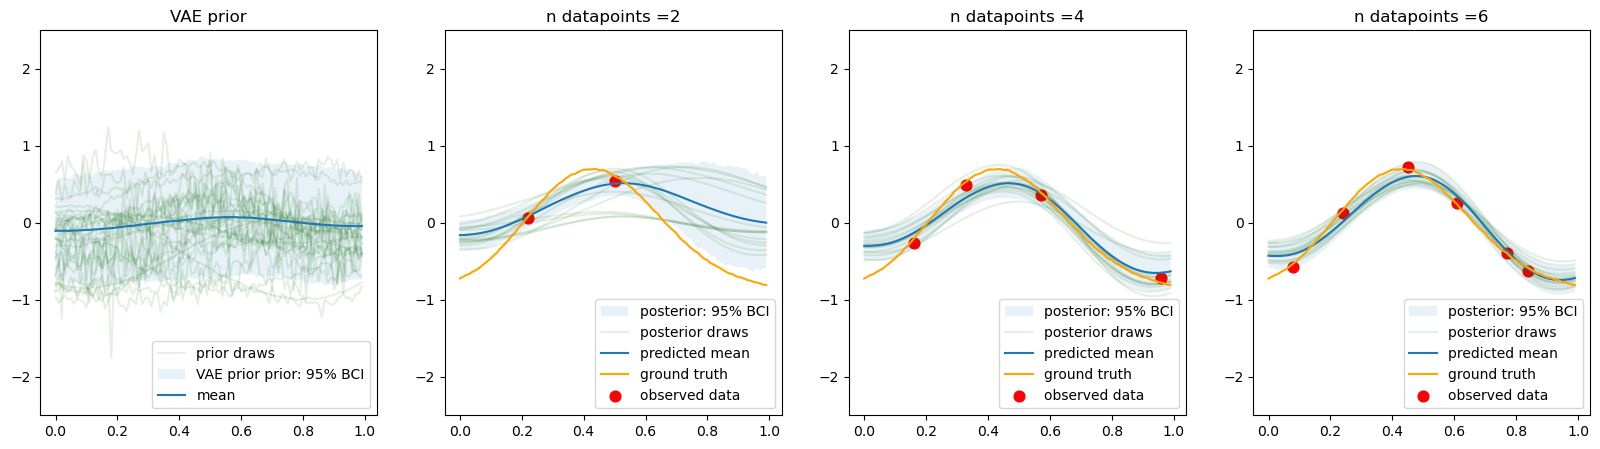

In [21]:
from plotting.plots import compare_inference_steps


compare_inference_steps(args["x"], ground_truth, x_obs_lst, y_obs_lst, prior_predictions, predictions_lst, title="VAE", save_path="gen_plots/01_inference_steps.png")

## Covariance matrices

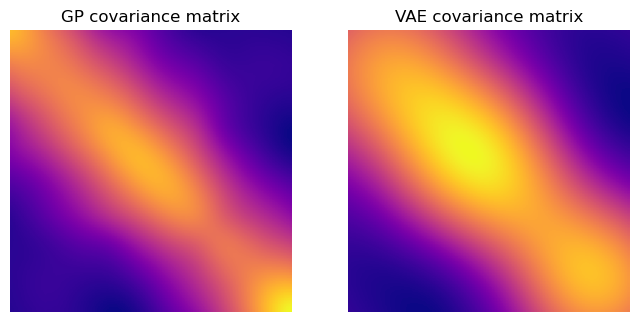

In [23]:
from plotting.plots import plot_cov_mat
import matplotlib.pyplot as plt

rng_key, rng_key_predict = random.split(random.PRNGKey(6))

gp_predictive = Predictive(OneDGP, num_samples=100)
gp_draws = gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']
gp_draws = gp_draws[~jnp.isnan(gp_draws).any(axis=1), :]

vae_predictive = Predictive(vae_sample, num_samples=100)

vae_draws = vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]
#vae_draws[~np.isnan(gp_draws).any(axis=1), :]



fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))

plot_cov_mat(gp_draws, "GP covariance matrix", axs[0])
plot_cov_mat(vae_draws, "VAE covariance matrix", axs[1])



